In [2]:
import torch
import matplotlib.pyplot as plt
import datetime
from torchvision import transforms

In [3]:
torch.cuda.is_available()

True

# From PyTorch to PyTorch Lightning

*COSCI 223: Machine Learning 3*

## Review
Let's review your first CNN architecture.

### Data Loading

In [4]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split

torch.manual_seed(143)

data_path = './data/cifar-10/'
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

cifar10 = CIFAR10(data_path, train=True, download=True)
cifar10_train, cifar10_val = random_split(cifar10, [40_000, 10_000])
cifar10_test = CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
img, label = cifar10_train[20]

In [6]:
transforms.functional.get_image_size(img)

[32, 32]

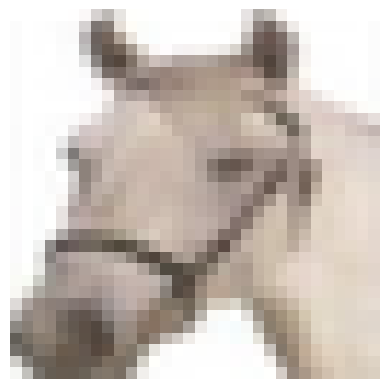

In [7]:
plt.imshow(img);
plt.axis('off');

### Data Preprocessing

#### Normalization of Inputs

In [8]:
from torchvision import transforms

cifar10 = CIFAR10(data_path, train=True, transform=transforms.ToTensor())

imgs = torch.stack([img_t for img_t, _ in cifar10], dim=3)

# compute for mean and standard deviation
means = imgs.view(3, -1).mean(dim=1).numpy()
stds = imgs.view(3, -1).std(dim=1).numpy()

transformations = transforms.Compose([
    transforms.ToTensor(),              # converts images to tensor
    transforms.Normalize(means, stds)   # normalization
])

# loading training-validation data then applying the transformations (to tensor and normalize)
# train = True
transformed_cifar10 = CIFAR10(
    data_path, train=True, download=False,
    transform=transformations
)
transformed_cifar10_train, transformed_cifar10_val = random_split(cifar10, [40_000, 10_000])

# loading test data then applying the transformation (to tensor)
# train = False -> test set
transformed_cifar10_test = CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.ToTensor()
)

In [9]:
# retrieve 2 classes only
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2_train = [(img, label_map[label]) for img, label in transformed_cifar10_train if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in [0, 2]]
cifar2_test = [(img, label_map[label]) for img, label in transformed_cifar10_test if label in [0, 2]]

In [10]:
print(f"Number of images in train set: {len(cifar2_train)}")
print(f"Number of images in val set: {len(cifar2_val)}")
print(f"Number of images in test set: {len(cifar2_test)}")

Number of images in train set: 8056
Number of images in val set: 1944
Number of images in test set: 2000


In [11]:
# dataLoader handles shuffling, batching, etc.
train_loader = DataLoader(cifar2_train, batch_size=64, shuffle=True)
val_loader = DataLoader(cifar2_val, batch_size=64, shuffle=False)
test_loader = DataLoader(cifar2_test, batch_size=64, shuffle=False)

### Model Building

<img src='./images/baseline-architecture.png' width=250/>

In [12]:
from torch import nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)

        return out

In [13]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [14]:
# pip install torch-summary

In [15]:
from torchsummary import summary

summary(model, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 32, 32]          448
├─Conv2d: 1-2                            [-1, 8, 16, 16]           1,160
├─Linear: 1-3                            [-1, 32]                  16,416
├─Linear: 1-4                            [-1, 2]                   66
Total params: 18,090
Trainable params: 18,090
Non-trainable params: 0
Total mult-adds (M): 0.75
Input size (MB): 0.01
Forward/backward pass size (MB): 0.14
Params size (MB): 0.07
Estimated Total Size (MB): 0.22


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 32, 32]          448
├─Conv2d: 1-2                            [-1, 8, 16, 16]           1,160
├─Linear: 1-3                            [-1, 32]                  16,416
├─Linear: 1-4                            [-1, 2]                   66
Total params: 18,090
Trainable params: 18,090
Non-trainable params: 0
Total mult-adds (M): 0.75
Input size (MB): 0.01
Forward/backward pass size (MB): 0.14
Params size (MB): 0.07
Estimated Total Size (MB): 0.22

#### Same CNN architecture but different approach...

In [16]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)  # pooling layers included in the init
        
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        # two conv/tanh + pool layers
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))

        x = x.view(-1, 8 * 8 * 8)
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)

        return x

In [17]:
model2 = Net2()
numel_list = [p.numel() for p in model2.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [18]:
summary(model2, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 32, 32]          448
├─MaxPool2d: 1-2                         [-1, 16, 16, 16]          --
├─Conv2d: 1-3                            [-1, 8, 16, 16]           1,160
├─MaxPool2d: 1-4                         [-1, 8, 8, 8]             --
├─Linear: 1-5                            [-1, 32]                  16,416
├─Linear: 1-6                            [-1, 2]                   66
Total params: 18,090
Trainable params: 18,090
Non-trainable params: 0
Total mult-adds (M): 0.75
Input size (MB): 0.01
Forward/backward pass size (MB): 0.14
Params size (MB): 0.07
Estimated Total Size (MB): 0.22


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 32, 32]          448
├─MaxPool2d: 1-2                         [-1, 16, 16, 16]          --
├─Conv2d: 1-3                            [-1, 8, 16, 16]           1,160
├─MaxPool2d: 1-4                         [-1, 8, 8, 8]             --
├─Linear: 1-5                            [-1, 32]                  16,416
├─Linear: 1-6                            [-1, 2]                   66
Total params: 18,090
Trainable params: 18,090
Non-trainable params: 0
Total mult-adds (M): 0.75
Input size (MB): 0.01
Forward/backward pass size (MB): 0.14
Params size (MB): 0.07
Estimated Total Size (MB): 0.22

### Model Training (on GPU)

In [19]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [30]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))          

In [31]:
from torch import optim

In [32]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(100, optimizer, model, loss_fn, train_loader=train_loader)

2023-04-24 02:43:42.233745 Epoch 1, Training loss 0.6868305073844062
2023-04-24 02:43:46.345855 Epoch 10, Training loss 0.43323809949178543
2023-04-24 02:43:51.159845 Epoch 20, Training loss 0.35777449276712203
2023-04-24 02:43:55.908205 Epoch 30, Training loss 0.33376511328277136
2023-04-24 02:43:59.550560 Epoch 40, Training loss 0.3165437527119167
2023-04-24 02:44:03.429415 Epoch 50, Training loss 0.3029357412504771
2023-04-24 02:44:07.804013 Epoch 60, Training loss 0.28813336245597354
2023-04-24 02:44:12.956535 Epoch 70, Training loss 0.2763141071985638
2023-04-24 02:44:17.546948 Epoch 80, Training loss 0.2594802530393714
2023-04-24 02:44:22.156337 Epoch 90, Training loss 0.2448070158088018
2023-04-24 02:44:26.666266 Epoch 100, Training loss 0.23238248182904153


### Model Validation

In [33]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))

In [34]:
validate(model, train_loader, val_loader)

Accuracy train: 0.90
Accuracy val: 0.88


# PyTorch Lightning

Sources: 
* [PyTorch Lightning website](https://www.pytorchlightning.ai/index.html)
* [Lightning AI github](https://github.com/Lightning-AI/lightning#pytorch-lightning-train-and-deploy-pytorch-at-scale)
* [From PyTorch to PyTorch Lightning--a gentle introduction, By: William Falcon](https://towardsdatascience.com/from-pytorch-to-pytorch-lightning-a-gentle-introduction-b371b7caaf09)
* [PyTorch Lightning Introduction - Colab Notebook](https://colab.research.google.com/drive/1Mowb4NzWlRCxzAFjOIJqUmmk_wAT-XP3)

PyTorch Lightning was started by William Falcon while completing his Ph.D. AI research at NYU CILVR and Facebook AI Research, with the vision of making it a foundational part of everyone's deep learning research code. As a result, the framework is designed to be extremely extensible while making state of the art AI research techniques (like TPU training) trivial.

PyTorch Lightning is just organized PyTorch. It makes coding complex networks simple. It structures your PyTorch code so it can abstract the details of training. This makes AI research scalable and fast to iterate on.

**Some advantages over unstructured PyTorch:**
* Models become hardware agnostic
* Code is clear to read 
* Easier to reproduce
* Make fewer mistakes because lightning handles the tricky engineering
* Minimal running speed overhead (about 300 ms per epoch compared with pure PyTorch)


In [35]:
# pip install pytorch-lightning

In [36]:
import pytorch_lightning as pl

In [37]:
# pip install torchmetrics
import torchmetrics

## Model Building (Conversion from PyTorch to PyTorch Lightning)

In [44]:
class LightningCNN(pl.LightningModule):   # use pl.LightningModule instead of nn.Module
    
    def __init__(self):                   # same as in pytorch
        super(LightningCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)        
        self.pool = nn.MaxPool2d(2, 2)  
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):                 # same as in pytorch
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))

        x = x.view(-1, 8 * 8 * 8)
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)

        return x
    
    def configure_optimizers(self):      # place the optimizer here
        optimizer = optim.SGD(self.parameters(), lr=1e-2)
        return optimizer
    
    def cross_entropy_loss(self, logits, labels):     # place the loss function here
        loss_fn = nn.CrossEntropyLoss(logits, labels)
        return loss_fn
    
    def training_step(self, batch, batch_idx):        # model training
        x, y = batch
        output = self.forward(x)
        preds = output.max(1).indices
        # accuracy
        self.accuracy = torchmetrics.functional.accuracy(preds, y, task ='binary')        
        self.log('train_acc', self.accuracy)        
        # loss
        loss = F.cross_entropy(output, y)
        self.log('train_loss', loss)

        return loss
    
    def validation_step(self, batch, batch_idx):     
        x, y = batch
        output = self.forward(x)
        preds = output.max(1).indices
        self.accuracy = torchmetrics.functional.accuracy(preds, y, task="binary")

        self.log('val_acc', self.accuracy)
        loss = F.cross_entropy(output, y)
        self.log('val_loss', loss)
             
    def test_step(self, batch, batch_idx):     # model testing
        x, y = batch
        output = self.forward(x)
        preds = output.max(1).indices
        self.accuracy = torchmetrics.functional.accuracy(preds, y, task="binary")

        self.log('test_acc', self.accuracy)
        loss = F.cross_entropy(output, y)
        self.log('test_loss', loss)

## Model Training

In [45]:
# pip install lightning

In [78]:
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import CSVLogger
logger = CSVLogger("logs", name="baseline_cnn-01")  # saves the metrics (as csv) in the "log"

model = LightningCNN()
trainer = pl.Trainer(max_epochs=100, logger=logger)
trainer.fit(model, train_loader, val_loader) # val_loader is used for validation during model training

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/mverdeprado/.conda/envs/msds2023-ml3-cnn/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/baseline_cnn-01/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 448   
1 | conv2 | Conv2d    | 1.2 K 
2 | pool  | MaxPool2d | 0     
3 | fc1   | Linear    | 16.4 K
4 | fc2   | Linear    | 66    
------------------------------------
18.1 K    Trainable params
0         Non-trainable params
18.1 K    Total params
0.072     Total estimated model params size (MB)
/home/mverdeprado/.conda/envs/msds2023-ml3-cnn/lib/python3.8/site-packages/lightning/fabric/loggers/csv_logs

Sanity Checking: 0it [00:00, ?it/s]

/home/mverdeprado/.conda/envs/msds2023-ml3-cnn/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mverdeprado/.conda/envs/msds2023-ml3-cnn/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Validation is usually done during training, traditionally after each training epoch. It can be used for hyperparameter optimization or tracking model performance during training. It’s a part of the training process.

## Model Evaluation: Testing

Testing is usually done once we are satisfied with the training and only with the best model selected from the validation metrics.

In [79]:
trainer.test(model, test_loader, ckpt_path="best")

Restoring states from the checkpoint path at logs/baseline_cnn-01/version_0/checkpoints/epoch=99-step=12600-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/baseline_cnn-01/version_0/checkpoints/epoch=99-step=12600-v1.ckpt
/home/mverdeprado/.conda/envs/msds2023-ml3-cnn/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8700000047683716
        test_loss            0.297913521528244
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8700000047683716, 'test_loss': 0.297913521528244}]

For visualization, you may use Tensorboard (currently available in Google Colab).

In [35]:
# Start tensorboard.
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 120239.

Or you may also use the CSV logger.

In [50]:
import pandas as pd
# read the csv file from the logs
df = pd.read_csv("logs/baseline_cnn-01/version_0/metrics.csv")
df

,train_acc,train_loss,epoch,step,val_acc,val_loss,test_acc,test_loss
0,0.625000,0.672977,0,49,NaN,NaN,NaN,NaN
1,0.656250,0.668710,0,99,NaN,NaN,NaN,NaN
2,NaN,NaN,0,125,0.691872,0.653568,NaN,NaN
3,0.750000,0.633268,1,149,NaN,NaN,NaN,NaN
4,0.734375,0.603591,1,199,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
348,0.890625,0.197895,99,12499,NaN,NaN,NaN,NaN
349,0.875000,0.259997,99,12549,NaN,NaN,NaN,NaN
350,0.910714,0.282732,99,12599,NaN,NaN,NaN,NaN
351,NaN,NaN,99,12599,0.881173,0.288567,NaN,NaN


In [65]:
val_acc = df.val_acc.dropna()
train_acc = df.train_acc.dropna()

<Axes: >

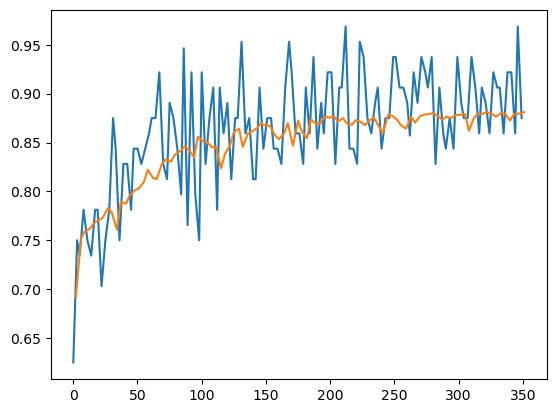

In [75]:
fig, ax = plt.subplots()
train_acc[::2].plot(ax=ax, color='tab:blue')
val_acc.plot(ax=ax, color='tab:orange')

<Axes: >

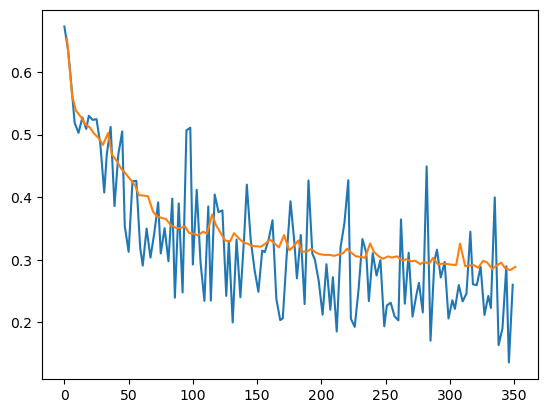

In [77]:
val_loss = df.val_loss.dropna()
train_loss = df.train_loss.dropna()

fig, ax = plt.subplots()
train_loss[::2].plot(ax=ax, color='tab:blue')
val_loss.plot(ax=ax, color='tab:orange')

# References:

* Falcon, W. (2020, November 8). *From PyTorch to PyTorch Lightning — A gentle introduction*. Medium. Retrieved April 17, 2023, from https://towardsdatascience.com/from-pytorch-to-pytorch-lightning-a-gentle-introduction-b371b7caaf09
* L. A. (n.d.). *GitHub - Lightning-AI/lightning: Deep learning framework to train, deploy, and ship AI products Lightning fast*. GitHub. Retrieved April 17, 2023, from https://github.com/Lightning-AI/lightning
* *PyTorch Lightning*. (n.d.). PyTorch Lightning. Retrieved April 17, 2023, from https://www.pytorchlightning.ai/index.html
* Viehmann, T., Stevens, E., Antiga, L. P. G. (2020). *Deep Learning with PyTorch*. United States: Manning.